In [2]:
# import cv2
# from PIL import Image
# from matplotlib import pyplot as plt
# import numpy as np
# from glass.inference.glass_runner import GlassRunner
# from glass.utils.logger import setup_logger
# from glass.utils.visualizer import visualize
# from matplotlib import pyplot as plt
# from paddleocr import PaddleOCR, draw_ocr
# import pandas as pd

# logger = setup_logger()

In [20]:
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Load, Extract, Transform data

In [66]:
TEST_DATA_DIR = "data/test_data/"
TEST_GT_DIR = TEST_DATA_DIR + "test_gt"
TEST_IMG_DIR = TEST_DATA_DIR + "Images"
NUM_FILES = 7

In [67]:
def get_file_names_from_folder(folder_path, num_files):
    files = os.listdir(folder_path)
    files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
    files = sorted(files)
    return files[:num_files]

def get_ground_truths(dir, file_names):
    columns = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'script', 'text']
    GTs = []
    for file_name in file_names:
        print(f"extracting {dir}/{file_name}")
        # get round truth as dataframe
        df = pd.read_csv(dir+'/'+file_name, delimiter=',', names=columns)
        
        # get df in format for evaluation
        gt = []
        for _, item in df.iterrows():
            gt.append(([[item.x1, item.y1], [item.x2, item.y2], [item.x3, item.y3], [item.x4, item.y4]], item.text))
            
        GTs.append(gt)
    return GTs

def get_images(dir, file_names):
    images = []
    for file_name in file_names:
        image = np.asarray(Image.open(dir+'/'+ file_name).convert('RGB')) # Inference is not supported for images with alpha channel
        images.append(image)
    return images

In [68]:
gt_filenames = get_file_names_from_folder(TEST_GT_DIR, num_files=NUM_FILES)
img_filenames = get_file_names_from_folder(TEST_IMG_DIR, num_files=NUM_FILES)

In [69]:
GTs = get_ground_truths(TEST_GT_DIR, gt_filenames)
images = get_images(TEST_IMG_DIR, img_filenames)

extracting data/test_data/test_gt/tr_img_01001.txt
extracting data/test_data/test_gt/tr_img_01002.txt
extracting data/test_data/test_gt/tr_img_01003.txt
extracting data/test_data/test_gt/tr_img_01004.txt
extracting data/test_data/test_gt/tr_img_01005.txt
extracting data/test_data/test_gt/tr_img_01006.txt
extracting data/test_data/test_gt/tr_img_01007.txt


In [70]:
len(GTs), len(images)

(7, 7)

# Get inference results

## Load models

### Glass

In [71]:
from glass.inference.glass_runner import GlassRunner
from glass.utils.logger import setup_logger
from glass.utils.visualizer import visualize

In [ ]:
model_path = './pretrained_models/glass_textocr.pth'
config_path = './configs/glass_finetune_textocr.yaml'
glass_runner = GlassRunner(model_path=model_path, config_path=config_path, post_process=True)

### Paddle OCR

In [ ]:
from paddleocr import PaddleOCR, draw_ocr

In [ ]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

## Perform Inference

In [73]:
glass_results = []
for img in images:
    glass_preds = glass_runner(img)
    glass_results.append(glass_preds)


[06/03 09:13:21 glass.inference.glass_runner]: Detected 3 raw word instances
[06/03 09:13:21 glass.postprocess.post_processor_rotated_boxes]: Merged and removed 1 Words
[06/03 09:13:21 glass.postprocess.post_processor_rotated_boxes]: Post-Process Word Time: 5.3 ms
[06/03 09:13:21 glass.inference.glass_runner]: Post-processing output is 1 word instances
[06/03 09:14:53 glass.inference.glass_runner]: Detected 10 raw word instances
[06/03 09:14:53 glass.postprocess.post_processor_rotated_boxes]: Merged and removed 5 Words
[06/03 09:14:53 glass.postprocess.post_processor_rotated_boxes]: Post-Process Word Time: 7.6 ms
[06/03 09:14:53 glass.inference.glass_runner]: Post-processing output is 5 word instances
[06/03 09:16:43 glass.inference.glass_runner]: Detected 42 raw word instances
[06/03 09:16:43 glass.postprocess.post_processor_rotated_boxes]: Merge time: 4.8 ms
[06/03 09:16:43 glass.postprocess.post_processor_rotated_boxes]: Merged and removed 26 Words
[06/03 09:16:43 glass.postprocess.

In [74]:
paddleocr_results = []
for img in images:
    paddle_preds = ocr.ocr(img, cls=True)
    paddleocr_results.append(paddle_preds)

[2024/06/03 09:22:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 2.0964441299438477
[2024/06/03 09:22:58] ppocr DEBUG: cls num  : 1, elapsed : 0.07600641250610352
[2024/06/03 09:22:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.3175220489501953
[2024/06/03 09:23:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 1.749990701675415
[2024/06/03 09:23:00] ppocr DEBUG: cls num  : 2, elapsed : 0.07336854934692383
[2024/06/03 09:23:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.9150936603546143
[2024/06/03 09:23:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 1.6896216869354248
[2024/06/03 09:23:02] ppocr DEBUG: cls num  : 3, elapsed : 0.11863470077514648
[2024/06/03 09:23:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.889885663986206
[2024/06/03 09:23:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 1.9504849910736084
[2024/06/03 09:23:05] ppocr DEBUG: cls num  : 2, elapsed : 0.06938719749450684
[2024/06/03 09:23:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.5718028545379639
[2024/06/03 09:23:07] ppocr DE

### Reformat predictions


### Glass

In [104]:
# glass_results[0]

In [82]:
from glass.evaluation.text_evaluator import get_instances_text

glass_preds = []

for preds in glass_results:
    glass_texts, glass_text_scores, _ = get_instances_text(preds.pred_text_prob, text_encoder=glass_runner.text_encoder)
    glass_bb_texts_pairs = []
    
    for item in zip(preds.pred_polygons.tolist(),glass_texts):
        glass_bb_texts_pairs.append(item)
    
    glass_preds.append(glass_bb_texts_pairs)

### PaddleOCR

In [93]:
paddleocr_results[0]

[[[[[582.0, 1205.0], [2820.0, 1240.0], [2814.0, 1647.0], [576.0, 1612.0]],
   ('TICKETS', 0.9954351782798767)]]]

In [102]:
paddle_texts_lst = []
for results in paddleocr_results:
    # print("*************",results)
    paddle_texts=[]
    for pred in results[0]:
        # print("#######",pred)
        paddle_texts.append((pred[0], pred[1][0]))
    paddle_texts_lst.append(paddle_texts)


In [103]:
len(paddle_texts_lst)

7

## Visulaization


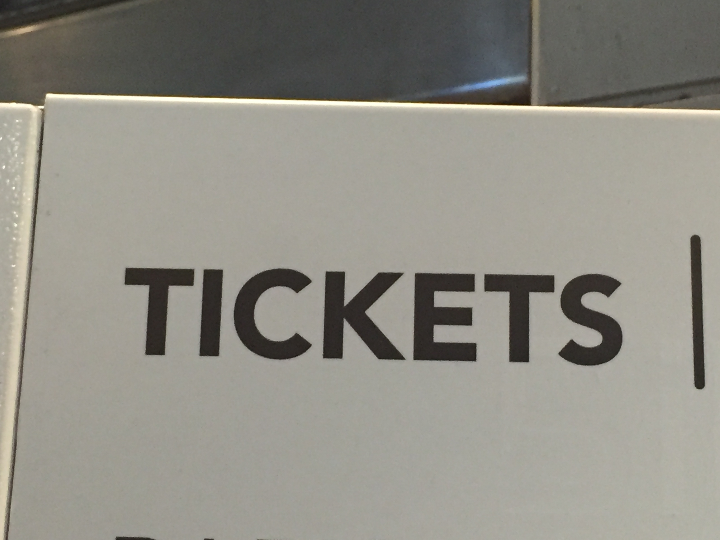

In [106]:
id=0
figure = visualize(preds=glass_results[id], image=images[id], text_encoder=glass_runner.text_encoder, vis_width=720, vis_text=True)
figure.show()

data/test_data/Images/tr_img_01002.jpg
[[[[945.0, 4.0], [1267.0, 4.0], [1267.0, 41.0], [945.0, 41.0]], ('#5TimesLonger', 0.9978266954421997)], [[[608.0, 809.0], [1614.0, 841.0], [1611.0, 928.0], [605.0, 896.0]], ('#5TimesLonger', 0.9928410649299622)]]


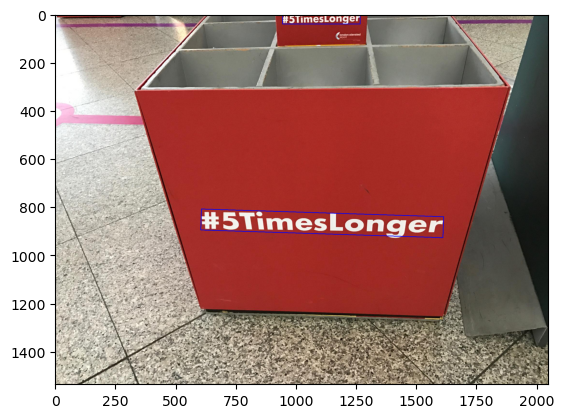

In [118]:
id = 1


file_path = TEST_IMG_DIR +'/'+ img_filenames[id]
print(file_path)

def read_image(file_path):
    image = np.asarray(Image.open(file_path).convert('RGB'))
    return image

img = read_image(file_path)
img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

for line in paddleocr_results[id]:
    print(line)

# Draw the results on the image
boxes = [elements[0] for elements in line]
image = draw_ocr(img_cv2, boxes)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Evaluate models

## loss functions

In [ ]:
import numpy as np
from shapely.geometry import Polygon
from scipy.optimize import linear_sum_assignment

def iou(boxA, boxB):
    polyA = Polygon(boxA)
    polyB = Polygon(boxB)
    if not polyA.is_valid or not polyB.is_valid:
        return 0.0
    inter_area = polyA.intersection(polyB).area
    union_area = polyA.area + polyB.area - inter_area
    return inter_area / union_area

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def cer(s1, s2):
    return levenshtein_distance(s1, s2) / len(s2)

def wer(s1, s2):
    s1_words = s1.split()
    s2_words = s2.split()
    return levenshtein_distance(s1_words, s2_words) / len(s2_words)

def calculate_cost_matrix(predictions, ground_truths):
    cost_matrix = np.zeros((len(predictions), len(ground_truths)))
    for i, pred in enumerate(predictions):
        for j, gt in enumerate(ground_truths):
            iou_score = iou(pred[0], gt[0])
            text_distance = levenshtein_distance(pred[1], gt[1])
            cost_matrix[i, j] = 1 - iou_score + text_distance  # Có thể điều chỉnh trọng số của IoU và text distance
    return cost_matrix

def calculate_text_cost_matrix(predictions, ground_truths):
    cost_matrix = np.zeros((len(predictions), len(ground_truths)))
    for i, pred in enumerate(predictions):
        for j, gt in enumerate(ground_truths):
            text_distance = levenshtein_distance(pred[1], gt[1])
            cost_matrix[i, j] = text_distance
    return cost_matrix

def precision_recall_f1(predictions, ground_truths, iou_threshold=0.5):
    cost_matrix = calculate_cost_matrix(predictions, ground_truths)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    true_positives = 0
    false_positives = len(predictions)
    false_negatives = len(ground_truths)

    for i, j in zip(row_ind, col_ind):
        if iou(predictions[i][0], ground_truths[j][0]) >= iou_threshold:
            true_positives += 1
            false_positives -= 1
            false_negatives -= 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

def precision_recall_f1_text(predictions, ground_truths, distance_threshold=0):
    cost_matrix = calculate_text_cost_matrix(predictions, ground_truths)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    true_positives = 0
    false_positives = len(predictions)
    false_negatives = len(ground_truths)

    for i, j in zip(row_ind, col_ind):
        if levenshtein_distance(predictions[i][1], ground_truths[j][1]) <= distance_threshold:
            true_positives += 1
            false_positives -= 1
            false_negatives -= 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

## Compare results

In [ ]:
cost_matrix = calculate_cost_matrix(glass_bb_texts_pairs, gt)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# In các cặp ghép
for i, j in zip(row_ind, col_ind):
    pred_box, pred_text = glass_bb_texts_pairs[i]
    gt_box, gt_text = gt[j]
    print(f"Prediction: Box={pred_box}, Text={pred_text}")
    print(f"Ground Truth: Box={gt_box}, Text={gt_text}")
    print(f"IoU: {iou(pred_box, gt_box)}, CER: {cer(pred_text, gt_text)}, WER: {wer(pred_text, gt_text)}")
    print()

precision, recall, f1 = precision_recall_f1(glass_bb_texts_pairs, gt)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

precision, recall, f1 = precision_recall_f1_text(glass_bb_texts_pairs, gt)
print(f"Text Precision: {precision:.2f}")
print(f"Text Recall: {recall:.2f}")
print(f"Text F1 Score: {f1:.2f}")

In [ ]:
cost_matrix = calculate_cost_matrix(paddle_texts, gt)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# In các cặp ghép
for i, j in zip(row_ind, col_ind):
    pred_box, pred_text = paddle_texts[i]
    gt_box, gt_text = gt[j]
    print(f"Prediction: Box={pred_box}, Text={pred_text}")
    print(f"Ground Truth: Box={gt_box}, Text={gt_text}")
    print(f"IoU: {iou(pred_box, gt_box)}, CER: {cer(pred_text, gt_text)}, WER: {wer(pred_text, gt_text)}")
    print()

precision, recall, f1 = precision_recall_f1(paddle_texts, gt)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

precision, recall, f1 = precision_recall_f1_text(paddle_texts, gt)
print(f"Text Precision: {precision:.2f}")
print(f"Text Recall: {recall:.2f}")
print(f"Text F1 Score: {f1:.2f}")

# Tracking with MLflow